# EMA Analyses

Kendra Wyant

In [ ]:
#|echo: FALSE

library(tidyverse)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

── Attaching packages ────────────────────────────────────── tidymodels 1.2.0 ──
✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.2.1
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.1.0
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     
── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks readr::spec()
✖ recipes::step()   masks stats::step()
• Use suppressPackageStartupMessages() to eliminate package startup messages

ℹ SHA-1 hash of file is "7b16d5bd2edc7abd5bbd964da4a3705d50646b68"

### Compliance

In [ ]:
path_shared <- "/Volumes/private/studydata/risk/data_processed/shared"
path_ema<- "/Volumes/private/studydata/risk/data_processed/ema"


visit_dates <- read_csv(file.path(path_shared, "visit_dates.csv"), col_types = cols())
ema_m <- vroom::vroom(file.path(path_shared, "ema_morning.csv"), col_types = vroom::cols()) %>% 
  mutate(start_date = with_tz(start_date, tzone = "America/Chicago"),
         subid = as.numeric(subid))
ema_l <- vroom::vroom(file.path(path_shared, "ema_later.csv"), col_types = vroom::cols()) %>% 
  mutate(start_date = with_tz(start_date, tzone = "America/Chicago"),
         subid = as.numeric(subid))

In [ ]:
disposition <- read_csv(file.path(path_ema, "disposition.csv"), col_types = cols())

# function to map over
get_study_days <- function(the_subid, dates) {
  start_study <- dates %>% filter(subid == the_subid) %>% pull(start_study)
  end_study <- dates %>% filter(subid == the_subid) %>% pull(end_study)
  study_days <- tibble(subid = the_subid, study_day = seq(start_study, end_study - days(1), by = "day")) 
  return(study_days)
}

sample <- disposition %>% 
  filter(analysis == "yes")

subids <- sample$subid
dates <- sample %>% 
  select(subid, start_study, end_study)

study_dates <- subids %>% 
  map_dfr(~get_study_days(.x, dates))

In [ ]:
ema <- ema_m |> 
  select(subid, start_date) |> 
  full_join(ema_l |> select(subid, start_date), by = c("subid", "start_date")) |> 
  mutate(start_date = date(start_date)) |> 
  filter(subid %in% subids)

# count EMAs per day
ema_count_4x <- ema |>  
  count(subid, start_date) |>
  mutate(n = if_else(n > 4, 4, as.numeric(n)))

# left join with study dates
ema_study_dates <- study_dates |>
  left_join(ema_count_4x, by = c("subid", "study_day" = "start_date")) |> 
  mutate(n = if_else(is.na(n), 0, n)) |> 
  mutate(n_prompts = 4)

# slice into 7 day bins
ema_study_weeks <- ema_study_dates |> 
  group_by(subid) |> 
  slice(1:7) |> 
  mutate(week = 1) |> 
  bind_rows(ema_study_dates |> 
    group_by(subid) |> 
    slice(8:14) |> 
    mutate(week = 2)) |> 
  bind_rows(ema_study_dates |> 
    group_by(subid) |> 
    slice(15:21) |> 
    mutate(week = 3)) |> 
  bind_rows(ema_study_dates |> 
    group_by(subid) |> 
    slice(22:28) |> 
    mutate(week = 4)) |> 
  bind_rows(ema_study_dates |> 
    group_by(subid) |> 
    slice(29:35) |> 
    mutate(week = 5)) |> 
  bind_rows(ema_study_dates |> 
    group_by(subid) |> 
    slice(36:42) |> 
    mutate(week = 6)) |> 
  bind_rows(ema_study_dates |> 
    group_by(subid) |> 
    slice(43:49) |> 
    mutate(week = 7)) |> 
  bind_rows(ema_study_dates |> 
    group_by(subid) |> 
    slice(50:56) |> 
    mutate(week = 8)) |> 
  bind_rows(ema_study_dates |> 
    group_by(subid) |> 
    slice(57:63) |> 
    mutate(week = 9)) |> 
  bind_rows(ema_study_dates |> 
    group_by(subid) |> 
    slice(64:70) |> 
    mutate(week = 10)) |> 
  bind_rows(ema_study_dates |> 
    group_by(subid) |> 
    slice(71:77) |> 
    mutate(week = 11)) |> 
  bind_rows(ema_study_dates |> 
    group_by(subid) |> 
    slice(78:84) |> 
    mutate(week = 12)) |> 
  ungroup()

ema_week_compliance_4x <- ema_study_weeks |> 
  group_by(subid, week) |> 
  summarize(sum_n = sum(n), sum_prompts = sum(n_prompts), .groups = "rowwise") |> 
  mutate(compliance = sum_n/sum_prompts) |> 
  ungroup()

ema_week_compliance_1x <- ema_study_weeks |>
  mutate(n = if_else(n > 1, 1, n),
         n_prompts = 1) |> 
  group_by(subid, week) |> 
  summarize(sum_n = sum(n), sum_prompts = sum(n_prompts), .groups = "rowwise") |> 
  mutate(compliance = sum_n/sum_prompts) |> 
  ungroup()

week_compliance_all <- ema_week_compliance_4x |> 
              mutate(compliance = compliance*100) |> 
              group_by(week) |> 
              summarize(mean_compliance = mean(compliance),
                        n = n(),
                        sd = sd(compliance)) |> 
              mutate(se = sd/sqrt(n),
                     signal = "4x Daily") |> 
  bind_rows(ema_week_compliance_1x |> 
              mutate(compliance = compliance*100) |> 
              group_by(week) |> 
              summarize(mean_compliance = mean(compliance),
                        n = n(),
                        sd = sd(compliance)) |> 
              mutate(se = sd/sqrt(n),
                     signal = "1x Daily")) 

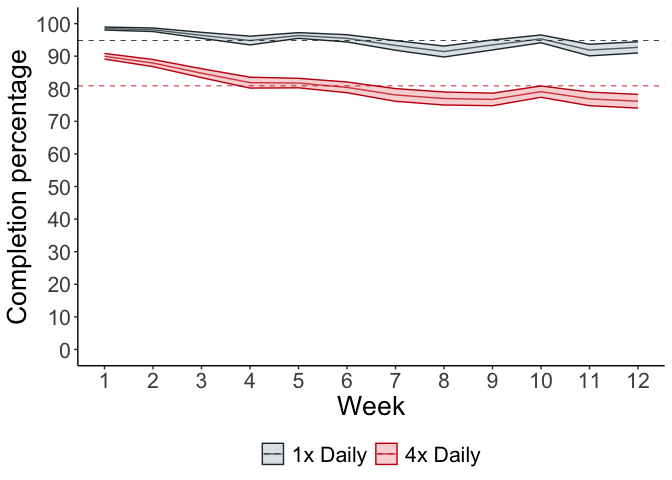

In [ ]:
#| label: compliance
#| out-height: 8in

week_compliance_all |> 
  group_by(week, signal) |> 
  ggplot(aes(x = week, y = mean_compliance, group = signal, color = signal, fill = signal)) +
  geom_line() +
  geom_ribbon(aes(ymin = mean_compliance - se, ymax = mean_compliance + se), alpha = .4) +
  theme_classic() +
  scale_color_manual(values = c("#263238", "#c5050c")) +
  scale_fill_manual(values = c("#b0bec5", "#ef9a9a")) +
  scale_x_continuous(name = "Week", 
                     breaks = seq(1, 12, 1)) +
  scale_y_continuous(name = "Completion percentage", 
                     breaks = seq(0, 100, 10), 
                     limits = c(0, 100)) +
  geom_hline(aes(yintercept = mean_compliance, color = signal), week_compliance_all |> 
               group_by(signal) |> 
               summarize(mean_compliance = mean(mean_compliance)),
             linetype = "dashed", linewidth = .3) +
  theme(legend.title = element_blank(),
        legend.position = "bottom",
        text = element_text(size = 20))